# Определение возраста покупателей по фотографии

###### Цель проекта:
Необходимо разработать модель для предсказания возраста человека по фотографии его лица. Проект выполняется для сети магазинов «Хлеб-Соль», которая планирует внедрить компьютерное зрение для анализа демографических характеристик покупателей.

###### Задачи проекта:

- Обработать и подготовить изображения для модели.
- Построить и обучить модель, которая на основе изображений лиц будет предсказывать реальный возраст человека.
- Оценить качество модели с использованием метрики MAE (среднее абсолютное отклонение), минимизировать значение метрики.


###### Описание данных:
Данные для проекта представлены в виде изображений лиц и сопутствующего файла labels.csv, который содержит два столбца:

- file_name — имя файла изображения.
- real_age — реальный возраст человека на изображении.


Файлы с изображениями хранятся в папке /final_files, а csv-файл с метками — в корневом каталоге папки.

###### Метрика качества:
Оценка модели осуществляется на основе метрики MAE, которая измеряет среднее абсолютное отклонение предсказаний от реальных значений возраста. Модель считается успешной, если она достигает минимального значения MAE.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from PIL import Image

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# Предварительный просмотр
display(data.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Размер выборки
display(f'Количество изображений: {len(data)}')

'Количество изображений: 7591'

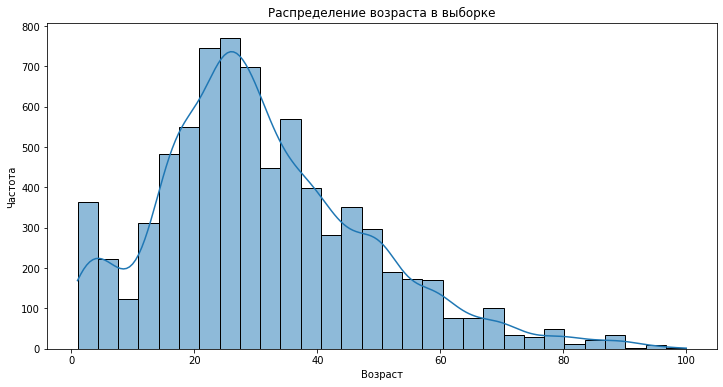

In [5]:
# График распределения возраста
plt.figure(figsize=(12, 6))
sns.histplot(data['real_age'], bins=30, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

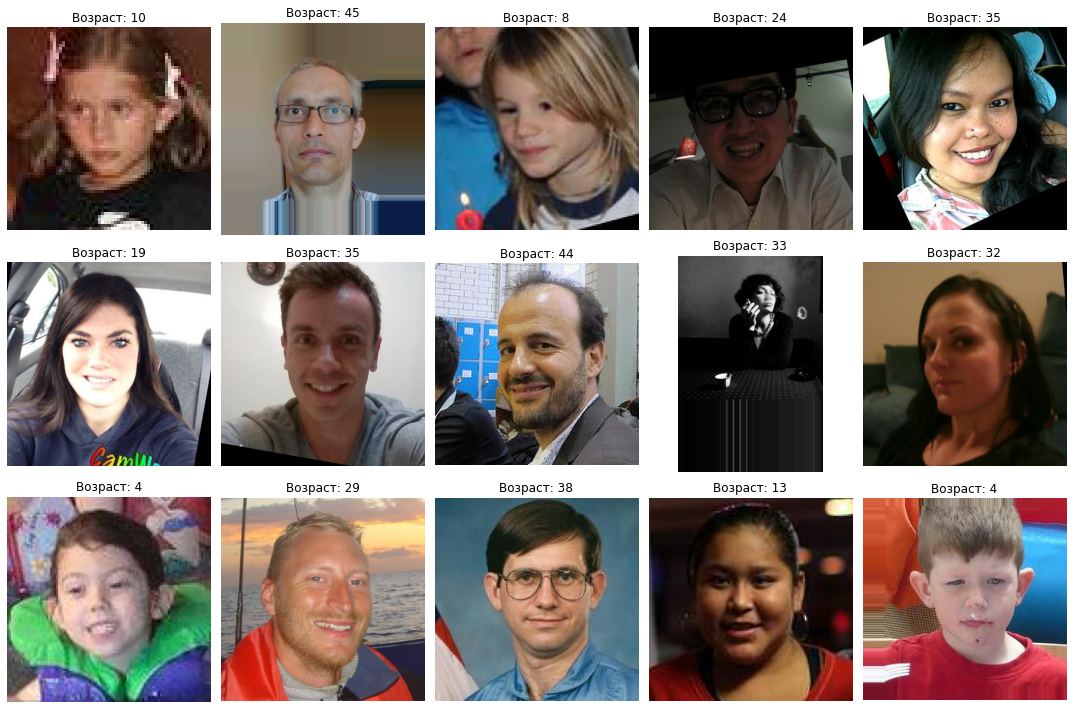

In [6]:
# Напечатаем 10–15 фотографий и посмотрите, как устроен датасет
# Путь к папке с изображениями
image_dir = '/datasets/faces/final_files/'

# Загрузка изображений
def load_image(image_name):
    img_path = os.path.join(image_dir, image_name)
    img = Image.open(img_path)
    return img

# Выбираем случайные изображения
sample_images = random.sample(list(data['file_name']), 15)

# Отображение изображений
plt.figure(figsize=(15, 10))
for i, img_name in enumerate(sample_images):
    plt.subplot(3, 5, i + 1)
    img = load_image(img_name)
    plt.imshow(img)
    plt.title(f'Возраст: {data[data["file_name"] == img_name]["real_age"].values[0]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

###### Выводы по исследовательскому анализу данных
- Размер выборки:

    - В наборе данных содержится 7591 изображение. Это достаточно большое количество для обучения модели, что позволяет использовать различные подходы для обучения и валидации.

- Распределение возраста:

    - График распределения возраста показывает, что большинство людей в выборке находится в возрасте от 20 до 40 лет. Это предполагает, что модель будет в основном ориентирована на эту возрастную группу.
    - Тем не менее, в выборке также присутствуют люди старшего возраста, вплоть до 100 лет. Это может добавить разнообразия в данные и улучшить обобщающие способности модели, но также может усложнить обучение из-за меньшего числа примеров для некоторых возрастных групп.

- Качество данных:

   - Изображения имеют хорошее качество и четкость, что важно для корректного обучения модели.

- Влияние на обучение модели:

    - Аугментация данных: Поскольку возрастная группа старше 40 лет представлена меньше, аугментация данных может помочь сбалансировать выборку и улучшить результаты модели.
    - Разделение на группы: Возможно, стоит рассмотреть обучение модели с учетом возрастных групп или использовать специальные методы для работы с несбалансированными данными.
    - Предобработка: Необходимо обратить внимание на возможные различия в освещении и качестве изображений, так как это может повлиять на обучение и точность модели.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке

```python

import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels_path = os.path.join(path, 'labels.csv')
    images_dir = os.path.join(path, 'final_files')

    # Чтение CSV файла
    labels = pd.read_csv(labels_path)

    # Создаем генератор данных для обучения
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255
    )

    # Генерация данных из датафрейма
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=images_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow


def load_test(path):
    labels_path = os.path.join(path, 'labels.csv')
    images_dir = os.path.join(path, 'final_files')

    # Чтение CSV файла
    labels = pd.read_csv(labels_path)

    # Создаем генератор данных для валидации
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    # Генерация данных из датафрейма
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=images_dir,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

2024-09-24 15:00:06.944876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-09-24 15:00:06.947007: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-09-24 15:00:07.981303: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-09-24 15:00:07.988581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-24 15:00:07.988650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-09-24 15:00:07.988709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-09-24 15:00:07.991056: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-09-24 15:00:07.991496: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-09-24 15:00:07.993916: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-09-24 15:00:07.995357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-09-24 15:00:07.995419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-09-24 15:00:07.998563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-09-24 15:00:08.204034: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-09-24 15:00:08.211444: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2024-09-24 15:00:08.212112: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x390dfb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-09-24 15:00:08.212141: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-09-24 15:00:08.351346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c22fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-24 15:00:08.351389: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-09-24 15:00:08.353086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-09-24 15:00:08.353138: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-09-24 15:00:08.353153: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-09-24 15:00:08.353177: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-09-24 15:00:08.353192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-09-24 15:00:08.353207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-09-24 15:00:08.353221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-09-24 15:00:08.353232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-09-24 15:00:08.356200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-09-24 15:00:08.356248: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-09-24 15:00:08.709123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-09-24 15:00:08.709177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-09-24 15:00:08.709187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-09-24 15:00:08.712327: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-24 15:00:08.712395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)

178/178 - 44s - loss: 14.0495 - mae: 2.8537 - val_loss: 72.2764 - val_mae: 6.2939
Epoch 16/20
178/178 - 44s - loss: 11.1543 - mae: 2.5657 - val_loss: 75.7457 - val_mae: 6.5754
Epoch 17/20
178/178 - 44s - loss: 12.5313 - mae: 2.6952 - val_loss: 81.1005 - val_mae: 7.0620
Epoch 18/20
178/178 - 44s - loss: 12.2203 - mae: 2.6581 - val_loss: 66.6416 - val_mae: 6.0223
Epoch 19/20
178/178 - 44s - loss: 11.8463 - mae: 2.6439 - val_loss: 70.4808 - val_mae: 6.3172
Epoch 20/20
178/178 - 44s - loss: 13.4990 - mae: 2.7732 - val_loss: 70.8490 - val_mae: 6.2637
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 70.8490 - mae: 6.2637
Test MAE: 6.2637

```

## Анализ обученной модели и выводы

- Модель, построенная на основе предобученной архитектуры ResNet50, использует её как базовую сеть для извлечения признаков. Далее в модели добавлен слой глобального усреднения (GlobalAveragePooling2D) для уменьшения размерности выходных признаков, а также плотный слой (Dense) с одним нейроном и функцией активации ReLU, чтобы предсказать возраст.

- Архитектура ResNet50 выбрана из-за её высокой производительности в задачах классификации изображений, а использование предварительно обученных весов на ImageNet позволяет ускорить обучение и достичь более высоких результатов при работе с небольшими размерами датасета.

- Оптимизатор Adam с небольшим значением скорости обучения (0.0005) выбран для стабильного и медленного схождения модели. Это помогает избежать резких колебаний в функции потерь, особенно при работе с небольшими обучающими данными. Модель обучалась в течение 20 эпох с функцией потерь MSE и метрикой MAE (средняя абсолютная ошибка)

- На протяжении обучения видно, что модель достаточно быстро снижает ошибку (MAE) на тренировочной выборке, достигая значения MAE 2.77 к последней эпохе. Это свидетельствует о том, что модель хорошо справляется с задачей предсказания возраста на тренировочных данных.

- Тестовое значение MAE составило 6.26 - это приемлемый результат для задачи предсказания возраста по изображениям.